In [ ]:
import time
import json
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import word_tokenize

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.metrics import accuracy_score, precision_recall_curve, f1_score, confusion_matrix
from sklearn.model_selection import KFold
# local imports
import ml_evaluation as ml_eval
import ml_helper
import ml_history
import dataset_generator as data_gen
# class imports
import HumorDataset as humor_ds
import EarlyStopping
import BalancedCELoss


# architecture inspired:
# https://n8henrie.com/2021/08/writing-a-transformer-classifier-in-pytorch/

# TODO: maybe KFold for cross validation?


#TODO: softmax for output layer or loss wih logits
#TODO: model.train() in training loop


### Generalisation ideas:
- **data augmentation** with Pseudo-labelling (if acc is it better)
- **Adversarial Training** adding small perturbations to the input data during training
- **Multi Sample Dropout** During training, multiple forward passes are performed with different dropout masks, and the resulting predictions are averaged.

### Learnings from papers:
- all used pretrained models berta like architectures
- voting from multiple models looks like a good approach (cross validation)

### TO DOS:
- improve Generalisation with avg cross validation
(https://aclanthology.org/2021.semeval-1.35.pdf)

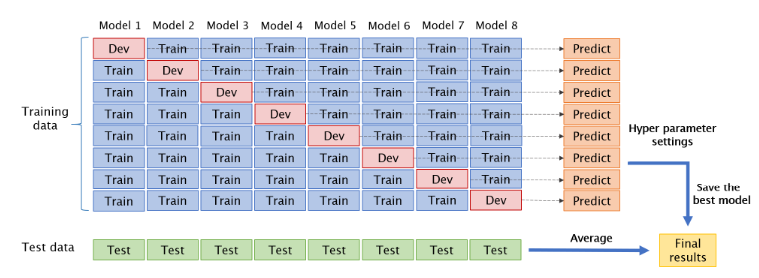

In [ ]:
torch.manual_seed(0)
np.random.seed(0)


best_model_filename = 'best_transformer_model.pt'

device = ml_helper.get_device(verbose=True)

Using device: cuda


### Load Embeddings

In [20]:
embedding_matrix, word_index, vocab_size, d_model = data_gen.create_embedding_matrix()

vocab_size = len(embedding_matrix)
d_model = len(embedding_matrix[0])
vocab_size, d_model = embedding_matrix.size()
print(f"vocab_size: {vocab_size}, d_model: {d_model}")

400002
vocab_size: 400002, d_model: 100
vocab_size: 400002, d_model: 100


### Define Model

In [21]:
class PositionalEncoding(nn.Module):
    """
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """

    def __init__(self, d_model, vocab_size=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(vocab_size, d_model)
        position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float()
            * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1), :]
        return self.dropout(x)


class TransformerBinaryClassifier(nn.Module):
    """
    Text classifier based on a pytorch TransformerEncoder.
    """

    def __init__(
        self,
        embeddings,
        nhead=8,
        dim_feedforward=2048,
        num_layers=6,
        positional_dropout=0.1,
        classifier_dropout=0.1,
        activation="relu",
    ):

        super().__init__()

        vocab_size, d_model = embeddings.size()
        assert d_model % nhead == 0, "nheads must divide evenly into d_model"

        self.emb = nn.Embedding.from_pretrained(embeddings, freeze=False)

        self.pos_encoder = PositionalEncoding(
            d_model=d_model,
            dropout=positional_dropout,
            vocab_size=vocab_size,
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=classifier_dropout,
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )
        # normalize to stabilize and stop overfitting
        self.batch_norm = nn.BatchNorm1d(d_model)
        self.classifier = nn.Linear(d_model, 2)
        self.d_model = d_model
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.emb(x) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        # normalize to stabilize and stop overfitting
        x = self.batch_norm(x)
        x = self.classifier(x)
        
        # TODO check if softmax is needed
        #x = self.softmax(x)
        return x


### Load data

In [22]:
X,y = data_gen.load_preprocess_data()

ret_dict = data_gen.split_data(X, y)


train 3945 3945
test 494 494
val 493 493


### Set hyper params

In [23]:
params = {
    # used for class balancing
    'equalize_classes_loss_factor': 0.15, # 0.15 (0.1 to 0.2)
    # training parameters
    'batch_size': 32, # 32 (16 to 64)
    'epochs': 100, # 100
    'lr': 1e-4, # 1e-5 (1e-6 to 1e-3)
    
    # NOTE: used for gradient clipping (needed for lstm and transformer)
    # use 0 to disable
    'clipping_max_norm': 0, # 0 (0.5 to 2.0)
    
    # patience for early stopping
    'early_stopping_patience': 5, # 5 (3 to 10)

    # learning rate scheduler
    'lr_scheduler_factor': 0.5, # 0.1 (0.05 to 0.2)
    'lr_scheduler_patience': 3, # 3 (2 to 5)

    # model parameters
    'nhead': 2, # 5
    'num_layers': 3, # 6
    'hidden_dim': 10, # 50

    # regularization parameters
    'positional_dropout': 0.5, # 0.1 (0.1 to 0.5)
    'classifier_dropout': 0.5, # 0.1 (0.1 to 0.5)
    'weight_decay': 1e-2 # 0.0  (1e-6 to 1e-2)
}

# Model initialization
model = TransformerBinaryClassifier(embeddings=embedding_matrix, 
                                    nhead=params['nhead'], 
                                    num_layers=params['num_layers'], 
                                    dim_feedforward=params['hidden_dim'],
                                    positional_dropout=params['positional_dropout'],
                                    classifier_dropout=params['classifier_dropout']
                                    )
model.to(device)
print('model created')

model created


c:\Users\felix\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


### create datasets

In [24]:
# NOTE: Info comes from data explore notebook: 280 is max length,
# 139 contains 80% and 192 contains 95% of the data
max_len = 280

train_dataset = humor_ds.TextDataset(ret_dict['train']['X'], ret_dict['train']['y'], word_index, max_len=max_len)
val_dataset =  humor_ds.TextDataset(ret_dict['val']['X'], ret_dict['val']['y'], word_index, max_len=max_len)
test_dataset =  humor_ds.TextDataset(ret_dict['test']['X'], ret_dict['test']['y'], word_index, max_len=max_len)

print('datasets length:', len(train_dataset), len(val_dataset))
#NOTE: overfitting test
#train_dataset.labels = train_dataset.labels[:100]
#train_dataset.texts = train_dataset.texts[:100]

train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)

# NOTE: samller because of batches not all data
print(f"train: {len(train_loader)}, val: {len(val_loader)}, test: {len(test_loader)}")

datasets length: 3945 493
train: 124, val: 16, test: 16


### Set training requirements

In [25]:
#criterion = nn.CrossEntropyLoss()
#criterion = nn.BCEWithLogitsLoss()
# alpha determines the weight of the imbalance penalty
criterion = BalancedCELoss.BalancedCELoss(alpha=params['equalize_classes_loss_factor'])


optimizer = torch.optim.Adam((p for p in model.parameters() if p.requires_grad), 
                            lr=params['lr']) #, 
                            #weight_decay=params['weight_decay'])
"""
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                        factor=params['lr_scheduler_factor'],
                                                        patience=params['lr_scheduler_patience'],
                                                        verbose=True)
"""
early_stopping = EarlyStopping.EarlyStopping(patience=params['early_stopping_patience'], verbose=False)


# Training loop

In [ ]:
hist = ml_history.History()

model.train()
# Training loop
for epoch in range(params['epochs']):
    epoch_start_time = time.time()
    hist.batch_reset()
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, labels = batch
        input_ids, labels = input_ids.to(device), labels.to(device)

        outputs = model(input_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=params['clipping_max_norm'])
        optimizer.step()
        preds = torch.argmax(outputs, dim=1)       
        # Update history
        hist.batch_update_train(loss.item(), outputs, labels)
    
    # Validation
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            input_ids, labels = batch
            input_ids, labels = input_ids.to(device), labels.to(device)
            outputs = model(input_ids)
            loss = criterion(outputs, labels)

            preds = torch.argmax(outputs, dim=1)
            # Update history
            hist.batch_update_val(loss.item(), outputs, labels)

    # Update history
    hist.update()
    
    epoch_end_time = time.time()
    hist.print_history(epoch + 1, params['epochs'], epoch_end_time - epoch_start_time)

    """
    # Step the scheduler
    scheduler.step(val_loss)
    
    """
    # Check early stopping
    early_stopping(hist.history['val_loss'][-1], model, best_model_filename)
    # if early_stopping.early_stop:
    #     print("Early stopping")
    #     break
    

Epoch   1/100 - 2.87s - loss: 0.7935 - accuracy: 0.4969 - val_loss: 2.3949 - val_accuracy: 0.4742
Epoch   2/100 - 2.70s - loss: 0.8777 - accuracy: 0.5114 - val_loss: 0.7464 - val_accuracy: 0.5005
Epoch   3/100 - 2.67s - loss: 0.8741 - accuracy: 0.4914 - val_loss: 0.7593 - val_accuracy: 0.5044
Epoch   4/100 - 2.65s - loss: 0.8460 - accuracy: 0.4999 - val_loss: 0.8106 - val_accuracy: 0.5287
Epoch   5/100 - 2.65s - loss: 0.8504 - accuracy: 0.5051 - val_loss: 0.8417 - val_accuracy: 0.4917
Epoch   6/100 - 2.70s - loss: 0.8398 - accuracy: 0.5114 - val_loss: 0.7328 - val_accuracy: 0.5365
Epoch   7/100 - 2.67s - loss: 0.8218 - accuracy: 0.5227 - val_loss: 0.8496 - val_accuracy: 0.5258
Epoch   8/100 - 2.63s - loss: 0.8164 - accuracy: 0.5248 - val_loss: 1.0123 - val_accuracy: 0.4742
Epoch   9/100 - 2.70s - loss: 0.8178 - accuracy: 0.5225 - val_loss: 0.8091 - val_accuracy: 0.5248
Epoch  10/100 - 2.75s - loss: 0.8085 - accuracy: 0.5308 - val_loss: 0.8591 - val_accuracy: 0.5258
Epoch  11/100 - 2.72

# Evaluation

In [ ]:
model.load_state_dict(torch.load(best_model_filename))

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for texts, labels in test_loader:
        #print(texts)
        texts, labels = texts.to(device), labels.to(device)
        outputs = model(texts)
        predictions = torch.argmax(outputs, dim=1)

        all_preds.extend(predictions.cpu())
        all_labels.extend(labels.cpu())

C:\Users\felix\AppData\Local\Temp\ipykernel_26112\1470113516.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoints/checkpoint.pt'

🚀 Finale Test Accuracy: 0.6194
🚀 Finale Test F1 Score: 0.6667


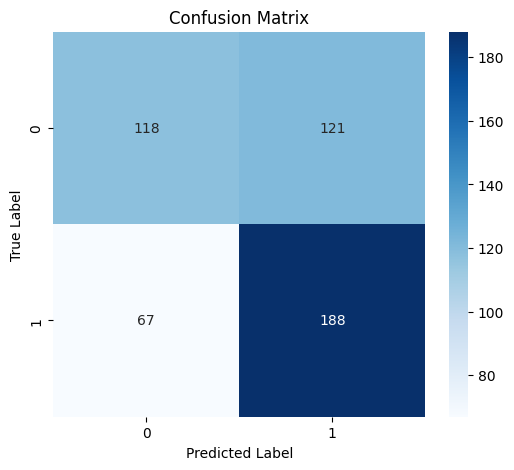

In [28]:
print(f'🚀 Finale Test Accuracy: {ml_eval.get_accuracy(all_preds, all_labels):.4f}')
print(f'🚀 Finale Test F1 Score: {ml_eval.get_f1_score(all_preds, all_labels):.4f}')

# Confusion matrix
con_plt = ml_eval.plot_confusion_matrix(all_preds, all_labels, ['0', '1'])
con_plt.show()

In [29]:
ml_eval.get_label_distribution(all_labels, all_preds)

Class 0: 0.64
Class 1: 0.36


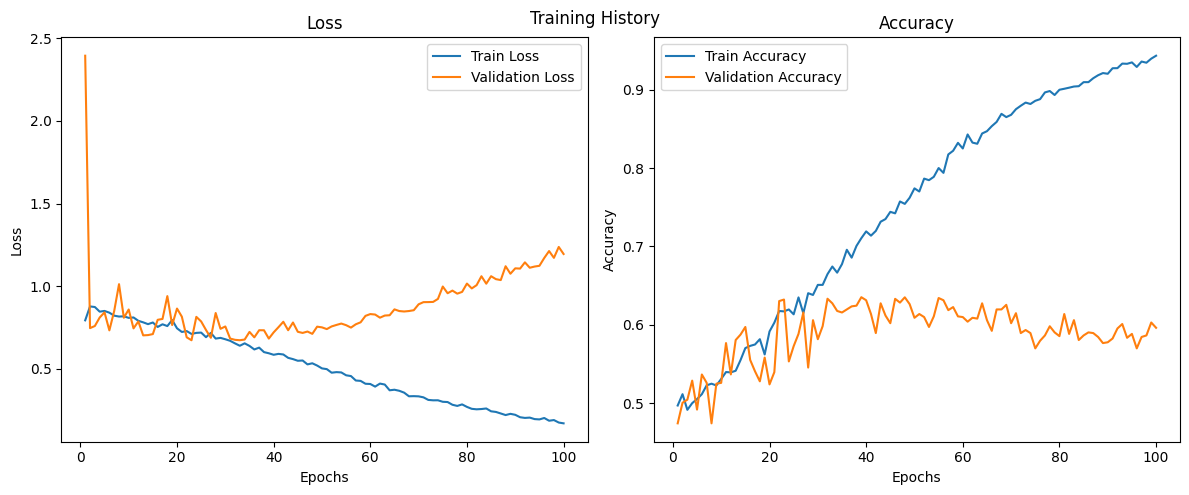

In [30]:
ml_eval.plot_training_history(hist).show()

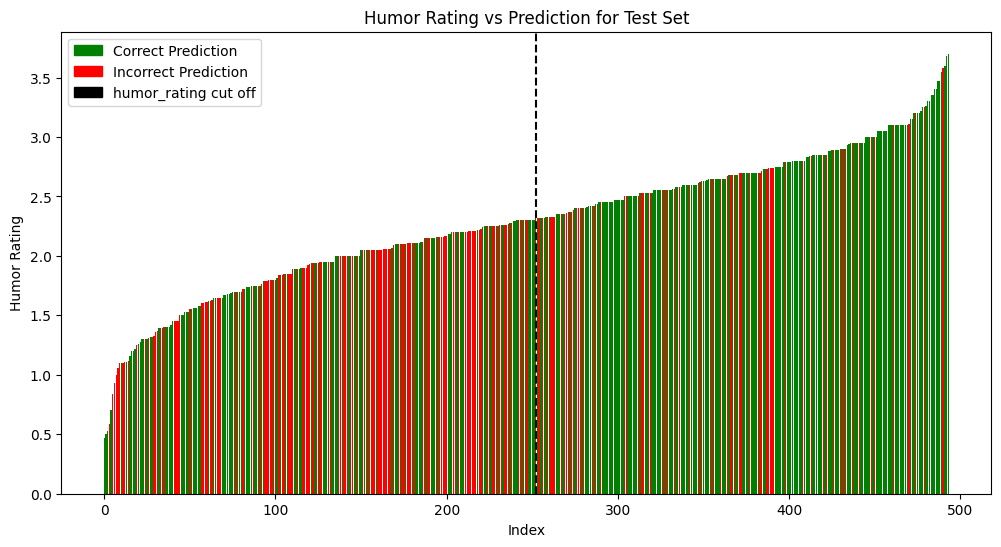

In [31]:
ml_eval.plot_rating_preds(all_preds, all_labels, test_dataset).show()